In [1]:
import sys
sys.path.append("../")

from utility.potential import *
from utility.propagation import *
from utility.units import CM_INV
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 16
from matplotlib.axes import Axes
from matplotlib.figure import Figure
from utility.plotting import *
from tqdm import tqdm

if not os.path.exists(DATA_PATH):
    os.makedirs(DATA_PATH)

SAVE_PATH = "../plots/"

@dataclass
class HarmonicPotential:
    mass_u: float
    
    omega_z: float
    omega_xy: float
    
    def value(self, r: Floating, theta: Floating) -> Floating:
        return 0.5 * self.mass_u * U * (r - 8) ** 2 *((self.omega_z * np.cos(theta)) ** 2 + (self.omega_xy * np.sin(theta)) ** 2)
    
    def show(self, r: FloatNDArray = np.linspace(0, 10, 300), theta: FloatNDArray = np.linspace(0, np.pi, 100)) -> tuple[Figure, Axes]:
        theta_mesh, r_mesh = np.meshgrid(theta, r, indexing="ij")
        potential_array = self.value(r_mesh, theta_mesh) / CM_INV
        potential_array = np.clip(potential_array, -np.inf, 4000)

        fig, ax = plt.subplots()
        CS = ax.contourf(r, theta, potential_array, levels=100)
        cbar = fig.colorbar(CS)
        cbar.ax.set_ylabel("Energy [cm$^{-1}$]")
        ax.set_xlabel("r [bohr]")
        ax.set_ylabel("$\\theta$ [rad]")

        return fig, ax

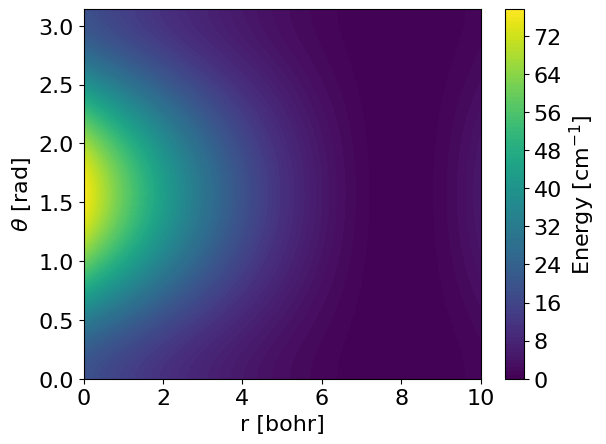

In [2]:
potential = HarmonicPotential(15, 1e-5, 2e-5)
fig, ax = potential.show();

In [3]:
def default_propagation(save_prefix: str, omega_init: int, j_tot: int, harmonic_potential: HarmonicPotential, prefactor: float = 1.) -> Propagation:
    propagation = Propagation(save_prefix, omega_init, omega_init, j_tot)
    propagation.params.wave_r0 = 5
    propagation.params.wave_r_sigma = 2
    propagation.params.mass_u = harmonic_potential.mass_u
    propagation.params.rot_const = 0.

    propagation.config.r_start = 3. + 10 / 512
    propagation.config.r_no = 512
    propagation.config.r_end = 13.
    propagation.config.polar_no = 32
    
    propagation.config.time_step = 3000
    propagation.config.steps_no = 2000
    propagation.config.coriolis_prefactor = prefactor

    propagation.provider.potential = harmonic_potential
    propagation.provider.transform_gamma = 0.

    propagation.config.im_time = True
    propagation.config.animation = AnimationConfig.All

    return propagation

In [15]:
propagation = default_propagation("harmonic_iso", 0, 2, HarmonicPotential(6, 1e-4, 1e-4))
propagation = propagation.into_split()

propagation.propagate()
propagation.save_savers()
print(propagation.mean_energy())

5.418854856841246e-05


In [8]:
propagation = default_propagation("harmonic_iso_coriolis", 2, 2, HarmonicPotential(6, 1e-4, 1e-4))
propagation.config.coriolis_omega_max = 6
propagation = propagation.into_split()

propagation.propagate()
propagation.save_savers()
print(propagation.mean_energy())

4.981435197150261e-05


In [6]:
energies = []
prefactors = np.logspace(-1, 1, 10)
for prefactor in tqdm(prefactors):
    propagation = default_propagation("harmonic_iso_coriolis", 2, 2, HarmonicPotential(6, 1e-4, 1e-4), prefactor = prefactor)
    propagation.config.coriolis_omega_max = 6
    propagation = propagation.into_split()

    propagation.propagate()
    energies.append(propagation.mean_energy())

100%|██████████| 10/10 [06:39<00:00, 39.97s/it]


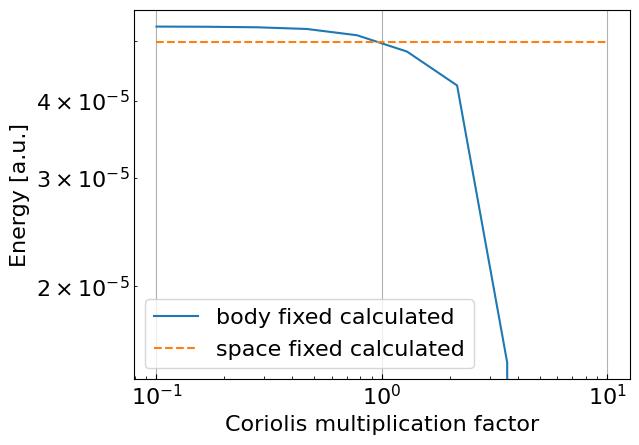

In [14]:
fig, ax = plot()
ax.plot(prefactors, energies, label = "body fixed calculated")
ax.plot(prefactors, [4.981437339409387e-05 for _ in prefactors], linestyle = "--", label = "space fixed calculated")

ax.set_xlabel("Coriolis multiplication factor")
ax.set_ylabel("Energy [a.u.]")
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend()
fig.savefig(f"{SAVE_PATH}/coriolis_convergence_test.pdf", bbox_inches = "tight");

# Using space-fixed coordinates

In [13]:
mass = 6.0
energy = 3000
proj_init = 0

omega_z = 1e-4
omega_xy = 1e-4

momentum = np.sqrt(2 * mass * U * energy * KELVIN)

time_grid = split.TimeGrid(3000.0, 2000, im_time = True)

r_grid = split.Grid.linear_continuos("r", 10 / 512, 10.0, 512, 0)
r_points = np.array(r_grid.points())

polar_points, weights = roots_legendre(100)
polar_points = np.flip(np.arccos(polar_points))
weights = np.flip(weights)

polar_grid = split.Grid.custom("theta", polar_points, weights, 1)

wave_r_init = np.array([split.gaussian_distribution(r_points[i], 5., 2., momentum) for i in range(r_grid.nodes_no())])
wave_polar_init = lpmv(proj_init, proj_init, np.cos(polar_points))
wave_init = np.outer(wave_r_init, wave_polar_init)
wave_function = split.WaveFunction(wave_init.flatten(), [r_grid, polar_grid])

r_mesh, polar_mesh = np.meshgrid(r_points, polar_points, indexing="ij")

potential_array = 0.5 * mass * U * (r_mesh - 5.) ** 2 * ((omega_z * np.cos(polar_mesh)) ** 2 + (omega_xy * np.sin(polar_mesh)) ** 2)
potential_propagator = split.n_dim_into_propagator(potential_array.shape, potential_array.flatten(), time_grid)

angular_transformation = split.associated_legendre_transformation(polar_grid, proj_init)

shape, angular_kinetic_op = split.rotational_hamiltonian(r_grid, polar_grid, mass, 0.)
angular_prop = split.n_dim_into_propagator(shape, angular_kinetic_op, time_grid)

kinetic_operator = split.kinetic_hamiltonian(r_grid, mass, energy)
kinetic_propagator = split.one_dim_into_propagator(kinetic_operator, r_grid, time_grid, step="full")

fft_transformation = split.FFTTransformation(r_grid, "momentum")

wave_saver = split.StateSaver("../data/2d_harmonic_wave", time_grid, r_grid, 120)
wave_2d_saver = split.WaveFunctionSaver("../data/2d_harmonic_wave_2d", time_grid, r_grid, polar_grid, 120)
angular_saver = split.StateSaver("../data/2d_harmonic_angular", time_grid, angular_transformation.transformed_grid(), 120)
leak_control = split.LeakControl(split.LossChecker("leak control"))

operation_stack = split.OperationStack()
leak_control.add_operation(operation_stack)
wave_2d_saver.add_operation(operation_stack)
wave_saver.add_operation(operation_stack)
potential_propagator.add_operation(operation_stack)
angular_transformation.add_operation(operation_stack, inverse_second=True)
angular_saver.add_operation(operation_stack)
angular_prop.add_operation(operation_stack)
fft_transformation.add_operation(operation_stack, inverse_second=True)
kinetic_propagator.add_operation(operation_stack)

propagation = split.Propagation()
propagation.set_time_grid(time_grid)
propagation.set_wave_function(wave_function)
propagation.set_operation_stack(operation_stack)

propagation.propagate()
propagation.save_savers()
print(propagation.mean_energy())

4.981437339409387e-05
